In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.optim import Adam
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [ ]:
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
) # [Tensor(1, 28, 28), int]
test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
) # [Tensor(1, 28, 28), int]

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


In [35]:
batch_size = 64

In [36]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True) # Tensor(64, 1, 28, 28), Tensor(64)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
from math import floor

In [ ]:
def output_shape_conv(input_shape, kernel_size, stride):
  output_shape = floor((input_shape - kernel_size)/stride) + 1
  return output_shape

def output_shape_trans(input_shape, kernel_size, stride):
  output_shape = (input_shape-1)*stride
  return output_shape

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, channels, kernel_size, stride=None):
    super().__init__()
    self.channels = channels
    self.n_layers = len(channels)
    assert len(kernel_size)==self.n_layers - 1
    if stride:
      assert len(stride)==self.n_layers-1
    self.kernel_size = kernel_size
    self.stride = stride if stride else [1 for i in range(self.n_layers-1)]
    self.conv = [nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size[i], stride=self.stride[i]) for i in range(self.n_layers-1)]
    self.output_shape = input_size
    for i in range(self.n_layers-1):
      self.output_shape = output_shape_conv(self.output_shape, self.kernel_size[i], self.stride[i])
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x):
    for i in range(self.n_layers-1):
      x = self.conv[i](x)
      x = self.relu(x)
    x = self.flatten(x)
    return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_shape, channels, kernel_size, stride=None):
        super().__init__()
        # Check
        self.n_layers = len(channels)
        assert len(kernel_size)==self.n_layers - 1
        if stride:
          assert len(stride)==self.n_layers - 1
        # Global parameters
        self.input_shape = input_shape
        self.channels = channels
        self.kernel_size = kernel_size
        self.stride = stride if stride else [1 for i in range(self.n_layers-1)]
        # Define layers
        self.conv = [nn.ConvTranspose2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size[i], stride=self.stride[i]) for i in range(self.n_layers-1)]
        self.relu = nn.ReLU()
        # Compute output shape
        self.output_shape = input_shape[-1]
        for i in range(self.n_layers-1):
          self.output_shape = output_shape_trans(self.output_shape, self.kernel_size[i], self.stride[i])

    def forward(self, x):
        x = x.reshape([x.size(0)]+self.input_shape)
        for i in range(self.n_layers-1):
            x = self.conv[i](x)
            x = self.relu(x)
        return x



In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, channels_conv, channels_t, kernel_size_conv, kernel_size_t, stride_conv=None, stride_t=None):
        super().__init__()
        assert channels_conv[-1]==channels_t[0]
        self.encoder = Encoder(input_size=input_size, channels=channels_conv, kernel_size=kernel_size_conv, stride=stride_conv)
        self.latent_dim = channels_conv[-1] * self.encoder.output_shape * self.encoder.output_shape
        self.fc1 = nn.Linear(self.latent_dim, 2)
        self.fc2 = nn.Linear(2, self.latent_dim)
        self.decoder = Decoder(input_shape=[channels_conv[-1], self.encoder.output_shape, self.encoder.output_shape],
                               channels=channels_t,
                               kernel_size=kernel_size_t,
                               stride=stride_t)

    def forward(self, x):
      x = self.encoder(x)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.decoder(x)
      return x


In [ ]:
vae = AutoEncoder(input_size=28, channels_conv=[1,3,3], channels_t=[3,3,1], kernel_size_conv=[3,3], kernel_size_t=[3,3])

In [ ]:
epochs = 10

criterion = nn.MSELoss()
optimizer = Adam(vae.parameters(), lr=0.01)

vae.train()
for epoch in range(epochs):
  for i, (X_batch, y_batch) in tqdm(enumerate(train_dataloader)):
    X_out = vae(X_batch)
    loss = criterion(X_out, X_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item()}')

5it [00:00, 14.02it/s]

Epoch 0, Batch 0, Loss: 0.09394200891256332


104it [00:03, 31.96it/s]

Epoch 0, Batch 100, Loss: 0.0789841040968895


203it [00:06, 21.31it/s]

Epoch 0, Batch 200, Loss: 0.06910029798746109


307it [00:11, 30.33it/s]

Epoch 0, Batch 300, Loss: 0.06966385990381241


407it [00:14, 31.75it/s]

Epoch 0, Batch 400, Loss: 0.05994686856865883


507it [00:17, 31.66it/s]

Epoch 0, Batch 500, Loss: 0.060111984610557556


604it [00:20, 21.17it/s]

Epoch 0, Batch 600, Loss: 0.0638701468706131


706it [00:24, 31.63it/s]

Epoch 0, Batch 700, Loss: 0.06054612994194031


806it [00:27, 31.54it/s]

Epoch 0, Batch 800, Loss: 0.05712421238422394


906it [00:30, 31.36it/s]

Epoch 0, Batch 900, Loss: 0.06110207736492157


938it [00:32, 29.30it/s]
4it [00:00, 32.73it/s]

Epoch 1, Batch 0, Loss: 0.05770888179540634


106it [00:04, 30.93it/s]

Epoch 1, Batch 100, Loss: 0.058942873030900955


206it [00:07, 31.89it/s]

Epoch 1, Batch 200, Loss: 0.05553041025996208


305it [00:11, 31.01it/s]

Epoch 1, Batch 300, Loss: 0.056458331644535065


404it [00:15, 20.91it/s]

Epoch 1, Batch 400, Loss: 0.06034845858812332


503it [00:18, 30.00it/s]

Epoch 1, Batch 500, Loss: 0.0536588653922081


607it [00:22, 31.30it/s]

Epoch 1, Batch 600, Loss: 0.05300908163189888


707it [00:25, 30.99it/s]

Epoch 1, Batch 700, Loss: 0.05438254401087761


802it [00:30, 18.71it/s]

Epoch 1, Batch 800, Loss: 0.055707164108753204


904it [00:35, 17.78it/s]

Epoch 1, Batch 900, Loss: 0.05612386390566826


938it [00:36, 25.85it/s]
2it [00:00, 16.68it/s]

Epoch 2, Batch 0, Loss: 0.05588461831212044


102it [00:04, 12.73it/s]

Epoch 2, Batch 100, Loss: 0.052690453827381134


204it [00:09, 31.60it/s]

Epoch 2, Batch 200, Loss: 0.0546429343521595


307it [00:14, 29.48it/s]

Epoch 2, Batch 300, Loss: 0.055648818612098694


403it [00:17, 28.61it/s]

Epoch 2, Batch 400, Loss: 0.05303210765123367


507it [00:22, 31.06it/s]

Epoch 2, Batch 500, Loss: 0.057185713201761246


607it [00:25, 31.39it/s]

Epoch 2, Batch 600, Loss: 0.05409009009599686


707it [00:28, 31.58it/s]

Epoch 2, Batch 700, Loss: 0.05250752344727516


803it [00:32, 20.72it/s]

Epoch 2, Batch 800, Loss: 0.0517905093729496


904it [00:36, 31.24it/s]

Epoch 2, Batch 900, Loss: 0.056335579603910446


938it [00:37, 25.10it/s]
4it [00:00, 33.01it/s]

Epoch 3, Batch 0, Loss: 0.051345884799957275


104it [00:03, 32.77it/s]

Epoch 3, Batch 100, Loss: 0.054409947246313095


204it [00:06, 30.46it/s]

Epoch 3, Batch 200, Loss: 0.04882277920842171


306it [00:10, 29.90it/s]

Epoch 3, Batch 300, Loss: 0.05335796996951103


406it [00:13, 32.26it/s]

Epoch 3, Batch 400, Loss: 0.05446671321988106


506it [00:17, 31.96it/s]

Epoch 3, Batch 500, Loss: 0.053828515112400055


602it [00:20, 26.83it/s]

Epoch 3, Batch 600, Loss: 0.05460303649306297


706it [00:24, 30.58it/s]

Epoch 3, Batch 700, Loss: 0.052334655076265335


804it [00:28, 31.35it/s]

Epoch 3, Batch 800, Loss: 0.05584413558244705


904it [00:31, 30.70it/s]

Epoch 3, Batch 900, Loss: 0.053818605840206146


938it [00:32, 28.82it/s]
4it [00:00, 31.08it/s]

Epoch 4, Batch 0, Loss: 0.0535251647233963


104it [00:04, 29.26it/s]

Epoch 4, Batch 100, Loss: 0.04861089587211609


204it [00:07, 30.84it/s]

Epoch 4, Batch 200, Loss: 0.048632096499204636


304it [00:11, 31.87it/s]

Epoch 4, Batch 300, Loss: 0.05079037696123123


404it [00:14, 27.95it/s]

Epoch 4, Batch 400, Loss: 0.05412685498595238


505it [00:18, 30.83it/s]

Epoch 4, Batch 500, Loss: 0.04932446777820587


605it [00:21, 31.97it/s]

Epoch 4, Batch 600, Loss: 0.054267656058073044


705it [00:24, 31.10it/s]

Epoch 4, Batch 700, Loss: 0.051405828446149826


803it [00:28, 21.00it/s]

Epoch 4, Batch 800, Loss: 0.05589127913117409


907it [00:32, 31.64it/s]

Epoch 4, Batch 900, Loss: 0.05173284187912941


938it [00:33, 28.01it/s]
4it [00:00, 31.34it/s]

Epoch 5, Batch 0, Loss: 0.04974094033241272


104it [00:03, 31.66it/s]

Epoch 5, Batch 100, Loss: 0.052319206297397614


204it [00:06, 31.67it/s]

Epoch 5, Batch 200, Loss: 0.05852515995502472


307it [00:10, 28.16it/s]

Epoch 5, Batch 300, Loss: 0.05241717770695686


407it [00:13, 32.78it/s]

Epoch 5, Batch 400, Loss: 0.053587138652801514


507it [00:17, 31.40it/s]

Epoch 5, Batch 500, Loss: 0.049543045461177826


607it [00:20, 31.90it/s]

Epoch 5, Batch 600, Loss: 0.050908163189888


705it [00:24, 30.64it/s]

Epoch 5, Batch 700, Loss: 0.05302753299474716


805it [00:27, 32.02it/s]

Epoch 5, Batch 800, Loss: 0.05561257526278496


905it [00:30, 30.92it/s]

Epoch 5, Batch 900, Loss: 0.052609581500291824


938it [00:31, 29.53it/s]
4it [00:00, 31.97it/s]

Epoch 6, Batch 0, Loss: 0.052595045417547226


105it [00:04, 21.00it/s]

Epoch 6, Batch 100, Loss: 0.04983660951256752


206it [00:07, 32.12it/s]

Epoch 6, Batch 200, Loss: 0.053337663412094116


306it [00:10, 31.98it/s]

Epoch 6, Batch 300, Loss: 0.057822562754154205


406it [00:13, 31.97it/s]

Epoch 6, Batch 400, Loss: 0.04844924807548523


503it [00:17, 20.21it/s]

Epoch 6, Batch 500, Loss: 0.05412977561354637


604it [00:21, 32.56it/s]

Epoch 6, Batch 600, Loss: 0.050417736172676086


704it [00:24, 32.19it/s]

Epoch 6, Batch 700, Loss: 0.05521019175648689


804it [00:27, 31.20it/s]

Epoch 6, Batch 800, Loss: 0.05202081799507141


906it [00:31, 27.61it/s]

Epoch 6, Batch 900, Loss: 0.05150114372372627


938it [00:32, 28.55it/s]
4it [00:00, 32.51it/s]

Epoch 7, Batch 0, Loss: 0.055457159876823425


104it [00:03, 32.34it/s]

Epoch 7, Batch 100, Loss: 0.05453578755259514


207it [00:06, 31.35it/s]

Epoch 7, Batch 200, Loss: 0.051588188856840134


305it [00:10, 20.05it/s]

Epoch 7, Batch 300, Loss: 0.05721108615398407


407it [00:14, 31.52it/s]

Epoch 7, Batch 400, Loss: 0.05014953017234802


507it [00:17, 32.28it/s]

Epoch 7, Batch 500, Loss: 0.05309562757611275


607it [00:20, 32.49it/s]

Epoch 7, Batch 600, Loss: 0.04742567986249924


703it [00:24, 20.83it/s]

Epoch 7, Batch 700, Loss: 0.05114525556564331


805it [00:27, 32.56it/s]

Epoch 7, Batch 800, Loss: 0.05494449660181999


905it [00:30, 31.91it/s]

Epoch 7, Batch 900, Loss: 0.05139976739883423


938it [00:31, 29.31it/s]
7it [00:00, 30.79it/s]

Epoch 8, Batch 0, Loss: 0.051122430711984634


105it [00:03, 23.89it/s]

Epoch 8, Batch 100, Loss: 0.05270352587103844


205it [00:07, 31.68it/s]

Epoch 8, Batch 200, Loss: 0.05129694566130638


304it [00:11, 26.55it/s]

Epoch 8, Batch 300, Loss: 0.05218270421028137


406it [00:15, 21.12it/s]

Epoch 8, Batch 400, Loss: 0.0499919094145298


507it [00:21, 31.44it/s]

Epoch 8, Batch 500, Loss: 0.05430566892027855


607it [00:24, 32.36it/s]

Epoch 8, Batch 600, Loss: 0.05079320818185806


707it [00:28, 32.12it/s]

Epoch 8, Batch 700, Loss: 0.05040379986166954


803it [00:31, 21.37it/s]

Epoch 8, Batch 800, Loss: 0.05002311244606972


906it [00:35, 32.18it/s]

Epoch 8, Batch 900, Loss: 0.052984315901994705


938it [00:36, 25.71it/s]
4it [00:00, 31.47it/s]

Epoch 9, Batch 0, Loss: 0.05337109416723251


104it [00:03, 30.85it/s]

Epoch 9, Batch 100, Loss: 0.05569680407643318


207it [00:06, 30.86it/s]

Epoch 9, Batch 200, Loss: 0.05122098699212074


306it [00:10, 31.46it/s]

Epoch 9, Batch 300, Loss: 0.050208255648612976


406it [00:14, 32.55it/s]

Epoch 9, Batch 400, Loss: 0.056472837924957275


506it [00:17, 32.47it/s]

Epoch 9, Batch 500, Loss: 0.051030538976192474


605it [00:20, 21.69it/s]

Epoch 9, Batch 600, Loss: 0.05738752335309982


707it [00:24, 31.86it/s]

Epoch 9, Batch 700, Loss: 0.053235024213790894


806it [00:27, 31.75it/s]

Epoch 9, Batch 800, Loss: 0.05073903128504753


906it [00:31, 32.89it/s]

Epoch 9, Batch 900, Loss: 0.05000262334942818


938it [00:32, 29.23it/s]


In [ ]:
from random import sample

In [ ]:
test_data[2]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

(500, 2)


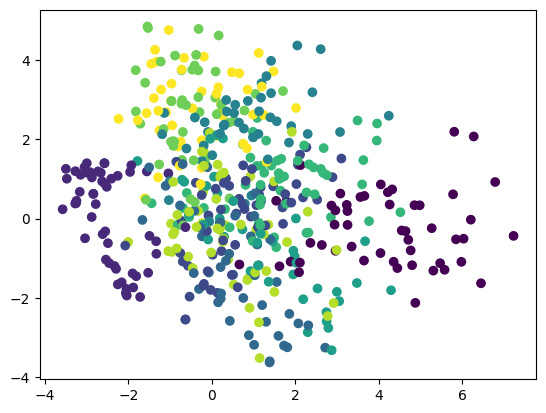

In [ ]:
# Pick at random 500 images from test set, AND their labels
random_indices = torch.randint(0, len(test_data), (500,))
test_sample = [test_data[i] for i in random_indices]

# Compute their latent representations
X, y = zip(*test_sample)
latent_X = []
for x in X:
  x = x.unsqueeze(0)
  x = vae.encoder(x)
  x = vae.fc1(x)
  latent_X.append(x.squeeze().detach().numpy())

# Plot them, with the color indicating their label
latent_X = np.array(latent_X)
print(latent_X.shape)
plt.scatter(latent_X[:, 0], latent_X[:, 1], c=y, cmap='viridis')

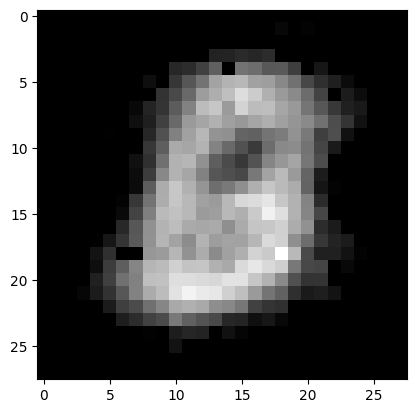

In [ ]:
x = test_data[0][0]
x = x.unsqueeze(0)

# To the latent space
latent = vae.encoder(x)
latent = vae.fc1(latent)

noise_scale = 0
noise = torch.rand(latent.shape)*noise_scale

latent = noise + torch.Tensor([1.3,0])

# Decoding
decoded = vae.fc2(latent)
decoded = vae.decoder(decoded)
plt.imshow(decoded.squeeze().detach().numpy(), cmap='grey')

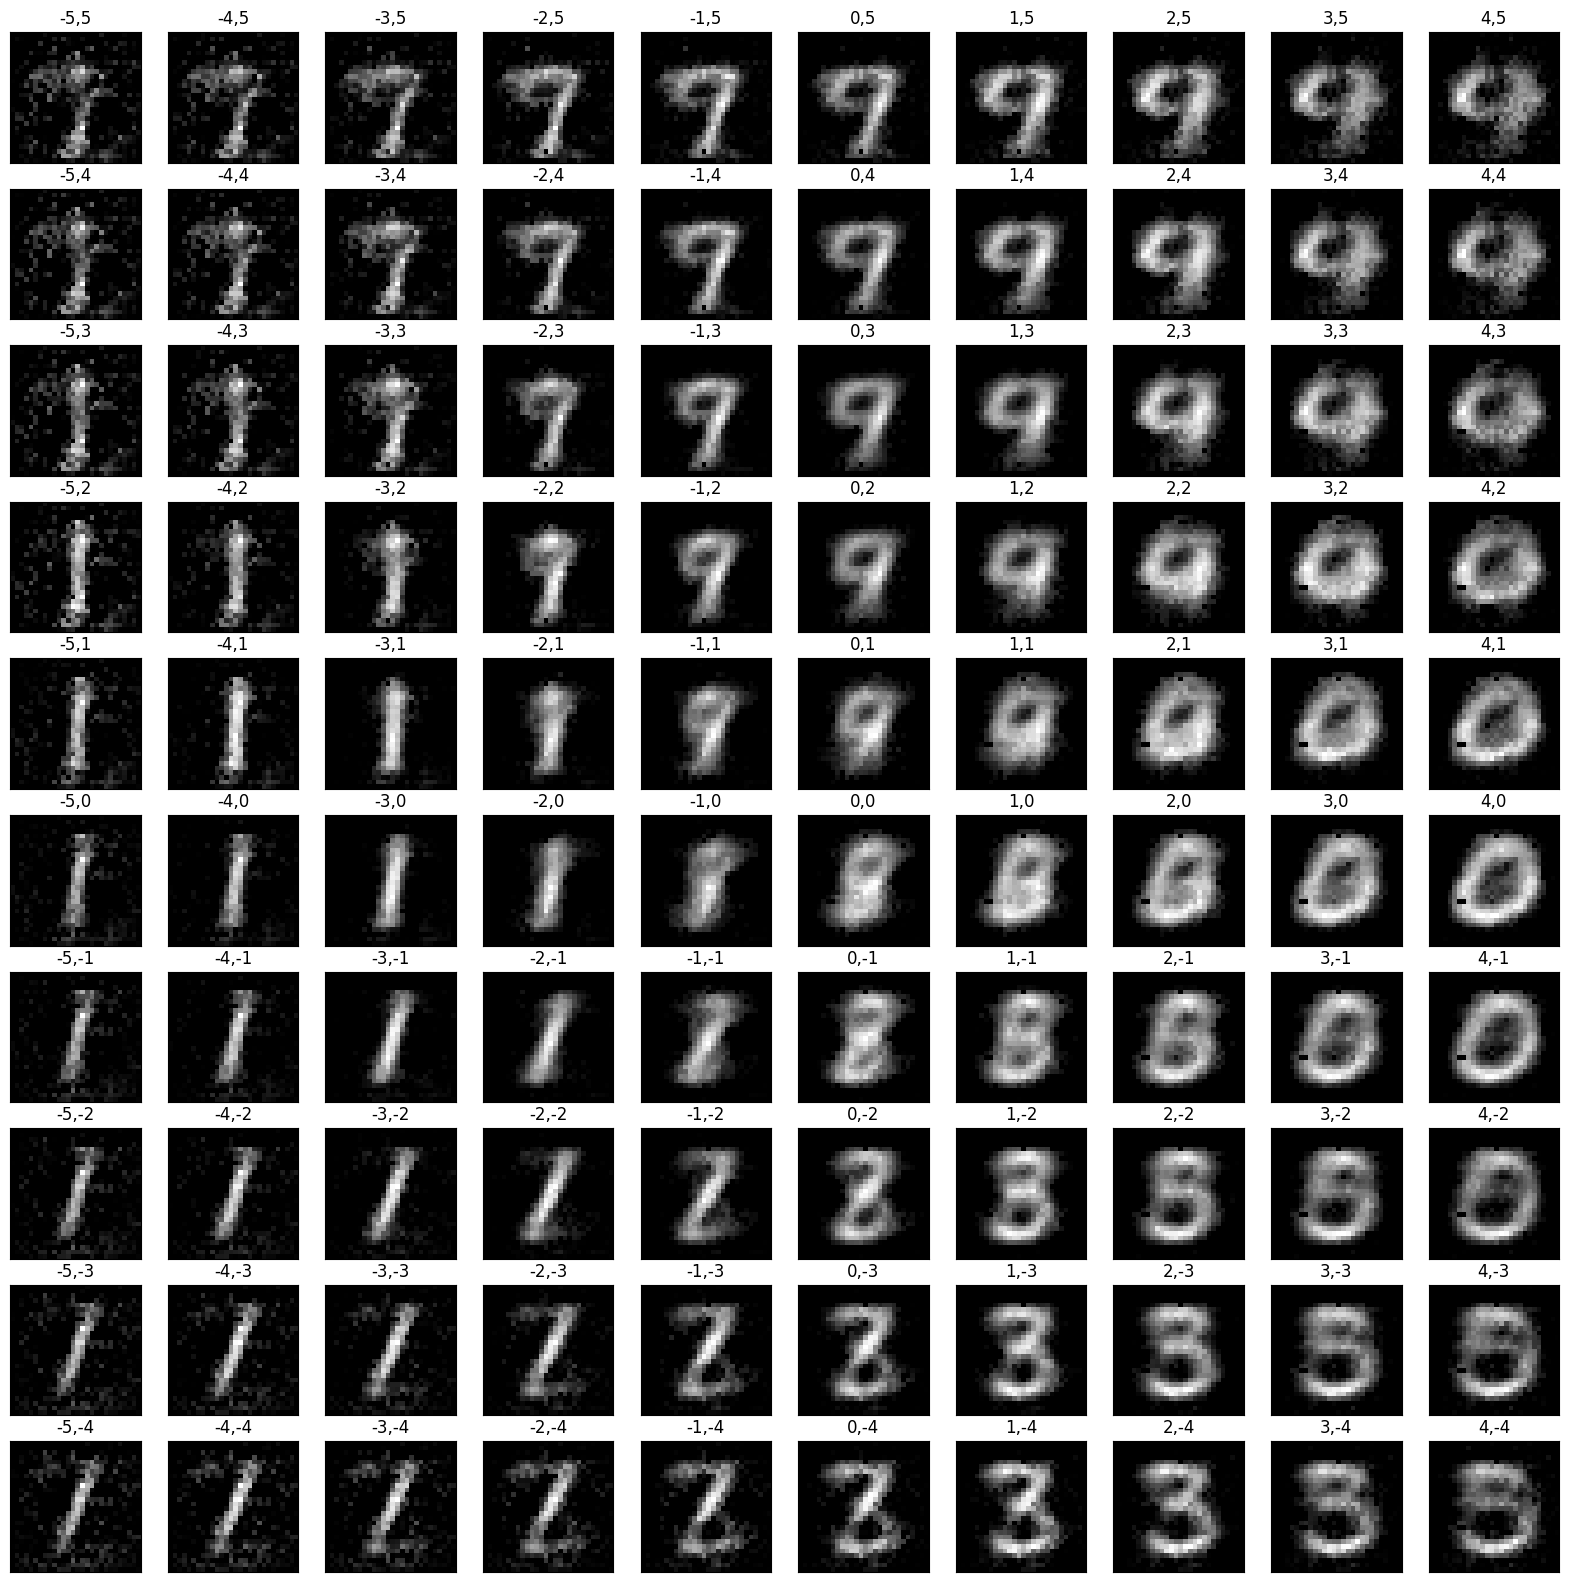

In [ ]:
n_rows, n_cols = 10, 10
fig, ax= plt.subplots(n_rows, n_cols, figsize=(20,20))

for i in range(n_rows):
  for j in range(n_cols):
    latent = torch.Tensor([j-5, 5-i]).unsqueeze(0)
    decoded = vae.fc2(latent)
    decoded = vae.decoder(decoded)
    ax[i, j].imshow(decoded.squeeze().detach().numpy(), cmap='grey')
    ax[i, j].set_title(f"{j-5},{5-i}")
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])


In [ ]:
reconstruct_x = vae(x.unsqueeze(0)+torch.rand([1,28,28])).squeeze()

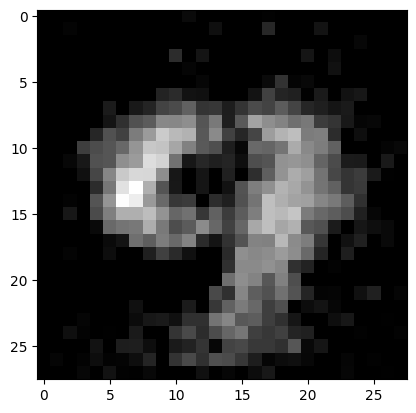

In [ ]:
plt.imshow(reconstruct_x.detach().numpy(), cmap='grey')

# Celebfaces Atributes

We will now turn to a variational auto-encoder trained for faces reconstruction.

Once it will be built with satisfactory performance, we will make use of the attributes to create a FaceApp-like interface.

## Building the Autoencoder

Two main differences since the previous autoencoder :
- The encoder will now output the mean and the log-variance of a normal distribution instead of a single point, to ensure continuity. The final layer will pick at random according to this distribution.
- We include in the loss the KL divergence between our distribution and the standard centered normal distribution, to center our outputs and bring them close.

Global imports

In [1]:
from torchvision.datasets import CelebA

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.optim import Adam
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import pickle as pkl
from torchvision.transforms.functional import to_pil_image

In [3]:
batch_size = 64

training_data = CelebA(
    root="data",
    split='train',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()])
) # [Tensor(3, 128, 128), int]
test_data = CelebA(
    root="data",
    split='test',
    download=True,
    transform={
        transforms.Resize((128, 128)),
        transforms.ToTensor()}
) # [Tensor(3, 128, 128), int]

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True) # Tensor(64, 1, 28, 28), Tensor(64)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
class Encoder(nn.Module):
  def __init__(self, input_shape, latent_dim, channels, kernels, stride=(2,2)):
    """
    input_shape : (Channels, Height, Width)
    kernel_size : (height, width)
    N convolutional layers -> channels_in, channels_out, kernel_size, stride for each
    Flatten
    2 Linear layers -> mu, logvar
    One Lambda layer
    """
    super().__init__()

    self.n_layers = len(channels)

    strides = [stride]*self.n_layers

    layers = []
    in_chan = input_shape[0]

    for out_chan, k, s in zip(channels, kernels, strides):
      layers.append(nn.Conv2d(in_chan, out_chan, k, s, padding=1))
      layers.append(nn.LeakyReLU())
      in_chan = out_chan

    self.layers = nn.Sequential(*layers)
    self.flatten = nn.Flatten()

    with torch.no_grad():
      dummy = torch.zeros(1, *input_shape)
      dummy_output = self.layers(dummy)
      self.inner_shape = dummy_output.shape[1:]
      self.flat_size = dummy_output.flatten(1).shape[1]

    self.mu = nn.Linear(self.flat_size, latent_dim)
    self.logvar = nn.Linear(self.flat_size, latent_dim)

  def forward(self, x):
    x = self.layers(x)
    x = self.flatten(x)
    mu, logvar = self.mu(x), self.logvar(x)
    output = mu + torch.exp(0.5*logvar)*torch.randn_like(logvar)
    return output, mu, logvar


In [5]:
class Decoder(nn.Module):
  def __init__(self, inner_shape, flat_size, latent_dim, channels, kernels, scale_factor=2, target_shape=None):
    super().__init__()

    self.n_layers = len(channels)
    self.inner_shape = inner_shape
    self.target_shape = target_shape

    scale_factors = [scale_factor]*self.n_layers

    
    """
    for out_chan, k, s in zip(channels, kernels, scale_factors):
      layers.append(nn.ConvTranspose2d(in_chan, out_chan, k, s))
      layers.append(nn.BatchNorm2d(out_chan))
      layers.append(nn.LeakyReLU())
      layers.append(nn.Dropout(p=0.15))
      in_chan = out_chan
    """
    layers = []
    in_chan = inner_shape[0]
    for i, (out_chan, k) in enumerate(zip(channels, kernels)):
      if i>0:
        layers.append(nn.Upsample(scale_factor=2, mode='nearest'))

      layers.append(nn.Conv2d(in_chan, out_chan, kernel_size=k, stride=1, padding=1))

      if i < len(channels)-1:
        layers.append(nn.BatchNorm2d(out_chan))
        layers.append(nn.LeakyReLU(0.2))

      in_chan = out_chan
    
    self.fc = nn.Linear(latent_dim, flat_size)#, bias=False)
    self.conv = nn.Sequential(*layers)
    self.final_act = nn.Sigmoid()


  def forward(self, x):
    x = self.fc(x)
    x = x.reshape((x.size(0),)+self.inner_shape)
    x = self.conv(x)
    x = self.final_act(x)
    if self.target_shape is not None:
      x = nn.functional.interpolate(x, size=self.target_shape, mode='bilinear', align_corners=False)
    return x

In [44]:
class VAE(nn.Module):
  def __init__(self, input_shape, channels_enc, channels_dec, kernel_enc, kernel_dec, stride_enc=(2,2), scale_factor=2, latent_dim = 200, target_shape=None):
    """
    Initialize an instance of variational auto-encoder.
    Parameters :
      - input_shape : shape of the image (channel, height, width)
      - channels encoder : number of channels between each layer of the encoder
      - channels decoder : same for the decoder
      - kernel_enc : array containing in order the kernel size of each convolutional layer of the encoder
      - kernel_dec : array containing in order the kernel size of each convolutional layer of the decoder
      - stride_enc : array containing in order the stride of each convolutional layer of the encoder
      - stride_dec : array containing in order the stride of each convolutional layer of the decoder
      - latent_dim : dimension of the latent space to which we project
    """
    super().__init__()
    self.encoder = Encoder(input_shape=input_shape, latent_dim=latent_dim, channels=channels_enc, kernels=kernel_enc, stride=stride_enc)
    self.decoder = Decoder(inner_shape=self.encoder.inner_shape, flat_size=self.encoder.flat_size, latent_dim=latent_dim, channels=channels_dec, kernels=kernel_dec, scale_factor=scale_factor, target_shape=target_shape)
    self.latent_dim = latent_dim

  def forward(self, x):
    x, mu, logvar = self.encoder(x)
    x = self.decoder(x)
    return x, mu, logvar


In [7]:
with open("../models/vae_promising.pkl", 'rb') as f:
    vae = pkl.load(f)

In [7]:
vae = VAE(input_shape=(3,128,128),
    channels_enc=[32,64,128,256],
    channels_dec=[128,64,32, 3],
    kernel_enc=[(3,3), (3,3), (3,3), (3,3)],
    kernel_dec=[(3,3), (3,3), (3,3), (3,3)],
    latent_dim=512,
    target_shape=(128,128))

In [14]:
def criterion(y1,y2, mu, logvar, beta=1e-2):
  kl_div = -1/2 * torch.mean(1+logvar-mu.pow(2)-logvar.exp())
  bce_loss = nn.BCELoss()
  bce = bce_loss(y1,y2)
  return bce, beta*kl_div

optimizer = Adam(vae.parameters(), lr=5e-4)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mu): Linear(in_features=16384, out_features=512, bias=True)
    (logvar): Linear(in_features=16384, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=16384, bias=True)
    (conv): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
nb_epochs = 2
count = 0

vae.train()
for epoch in range(nb_epochs):
  for idx, (X_batch, _) in tqdm(enumerate(train_dataloader)):
    optimizer.zero_grad()
    X_batch = X_batch.to(device)
    X_reconst, mu, logvar = vae(X_batch)
    bce, kl = criterion(X_reconst, X_batch, mu, logvar)
    loss = bce+kl
    loss.backward()
    optimizer.step()
    count += X_batch.size(0)
    if idx%100==0:
      print(f"Epoch {epoch}, Batch {idx} : BCE = {bce}, KL = {kl}")
      """
      sample = training_data[0][0].unsqueeze(0).to(device)
      sample, _, _ = vae(sample)
      sample = sample.squeeze(0)
      img = to_pil_image(sample)
      plt.imshow(to_pil_image(sample))
      img.save(f"../data/image{epoch}-{idx/100}.jpg")
      """


4it [00:00, 15.26it/s]

Epoch 0, Batch 0 : BCE = 0.4824560582637787, KL = 0.005712681915611029


104it [00:06, 14.75it/s]

Epoch 0, Batch 100 : BCE = 0.5040697455406189, KL = 0.005734488368034363


202it [00:13, 14.59it/s]

Epoch 0, Batch 200 : BCE = 0.4837440848350525, KL = 0.006027713418006897


302it [00:20, 14.59it/s]

Epoch 0, Batch 300 : BCE = 0.47899603843688965, KL = 0.005704997107386589


402it [00:26, 14.54it/s]

Epoch 0, Batch 400 : BCE = 0.490625262260437, KL = 0.0057090651243925095


502it [00:33, 14.25it/s]

Epoch 0, Batch 500 : BCE = 0.4848007559776306, KL = 0.005884552840143442


604it [00:40, 14.70it/s]

Epoch 0, Batch 600 : BCE = 0.4969831705093384, KL = 0.005642143543809652


702it [00:47, 14.62it/s]

Epoch 0, Batch 700 : BCE = 0.473935604095459, KL = 0.006016603671014309


804it [00:54, 14.86it/s]

Epoch 0, Batch 800 : BCE = 0.46661633253097534, KL = 0.0059532285667955875


902it [01:01, 14.62it/s]

Epoch 0, Batch 900 : BCE = 0.4886138439178467, KL = 0.005621191114187241


1002it [01:07, 14.31it/s]

Epoch 0, Batch 1000 : BCE = 0.48905906081199646, KL = 0.005547202657908201


1102it [01:14, 14.35it/s]

Epoch 0, Batch 1100 : BCE = 0.4796544909477234, KL = 0.005918571725487709


1202it [01:21, 14.22it/s]

Epoch 0, Batch 1200 : BCE = 0.5076320171356201, KL = 0.005468030925840139


1302it [01:28, 13.87it/s]

Epoch 0, Batch 1300 : BCE = 0.4892076253890991, KL = 0.005907066166400909


1402it [01:35, 14.84it/s]

Epoch 0, Batch 1400 : BCE = 0.5161991119384766, KL = 0.00581770297139883


1502it [01:42, 14.59it/s]

Epoch 0, Batch 1500 : BCE = 0.5090858340263367, KL = 0.005505152978003025


1602it [01:48, 14.62it/s]

Epoch 0, Batch 1600 : BCE = 0.5063332915306091, KL = 0.005803148727864027


1702it [01:55, 14.65it/s]

Epoch 0, Batch 1700 : BCE = 0.4995867609977722, KL = 0.005729051772505045


1804it [02:02, 14.76it/s]

Epoch 0, Batch 1800 : BCE = 0.4965556561946869, KL = 0.005968400277197361


1902it [02:09, 14.60it/s]

Epoch 0, Batch 1900 : BCE = 0.4847652316093445, KL = 0.005699558183550835


2004it [02:16, 14.98it/s]

Epoch 0, Batch 2000 : BCE = 0.49677062034606934, KL = 0.005470110569149256


2102it [02:22, 14.55it/s]

Epoch 0, Batch 2100 : BCE = 0.49370574951171875, KL = 0.005767439492046833


2202it [02:29, 14.64it/s]

Epoch 0, Batch 2200 : BCE = 0.48554670810699463, KL = 0.005741160828620195


2302it [02:36, 14.67it/s]

Epoch 0, Batch 2300 : BCE = 0.4981655478477478, KL = 0.0056915972381830215


2402it [02:43, 14.24it/s]

Epoch 0, Batch 2400 : BCE = 0.4925919771194458, KL = 0.005926871206611395


2504it [02:50, 14.81it/s]

Epoch 0, Batch 2500 : BCE = 0.5063782930374146, KL = 0.005890201777219772


2544it [02:53, 14.70it/s]
2it [00:00, 11.13it/s]

Epoch 1, Batch 0 : BCE = 0.5035262107849121, KL = 0.005897940136492252


102it [00:07, 14.52it/s]

Epoch 1, Batch 100 : BCE = 0.48783788084983826, KL = 0.006110896822065115


204it [00:14, 14.92it/s]

Epoch 1, Batch 200 : BCE = 0.4699011743068695, KL = 0.0056207370944321156


302it [00:21, 14.56it/s]

Epoch 1, Batch 300 : BCE = 0.47970327734947205, KL = 0.005812540650367737


402it [00:27, 14.50it/s]

Epoch 1, Batch 400 : BCE = 0.49715107679367065, KL = 0.005988492630422115


502it [00:34, 14.53it/s]

Epoch 1, Batch 500 : BCE = 0.47958850860595703, KL = 0.005902785342186689


602it [00:41, 14.65it/s]

Epoch 1, Batch 600 : BCE = 0.49668535590171814, KL = 0.005725898779928684


702it [00:48, 14.27it/s]

Epoch 1, Batch 700 : BCE = 0.4822143018245697, KL = 0.005949823651462793


802it [00:55, 12.00it/s]

Epoch 1, Batch 800 : BCE = 0.4860270917415619, KL = 0.0060789380222558975


902it [01:03, 14.07it/s]

Epoch 1, Batch 900 : BCE = 0.49474796652793884, KL = 0.0057799331843853


1002it [01:10, 14.09it/s]

Epoch 1, Batch 1000 : BCE = 0.4904818534851074, KL = 0.005821314174681902


1102it [01:18, 11.98it/s]

Epoch 1, Batch 1100 : BCE = 0.507187008857727, KL = 0.005810860078781843


1202it [01:26, 12.13it/s]

Epoch 1, Batch 1200 : BCE = 0.48891472816467285, KL = 0.006187207531183958


1302it [01:33, 14.67it/s]

Epoch 1, Batch 1300 : BCE = 0.4946611523628235, KL = 0.005748370662331581


1402it [01:40, 14.11it/s]

Epoch 1, Batch 1400 : BCE = 0.5021378993988037, KL = 0.006183820776641369


1502it [01:47, 14.09it/s]

Epoch 1, Batch 1500 : BCE = 0.46921631693840027, KL = 0.005726669915020466


1604it [01:54, 14.97it/s]

Epoch 1, Batch 1600 : BCE = 0.4942285418510437, KL = 0.005975563544780016


1704it [02:00, 14.93it/s]

Epoch 1, Batch 1700 : BCE = 0.48655828833580017, KL = 0.006194802466779947


1802it [02:07, 14.77it/s]

Epoch 1, Batch 1800 : BCE = 0.49512219429016113, KL = 0.005620155017822981


1904it [02:14, 14.90it/s]

Epoch 1, Batch 1900 : BCE = 0.4968540668487549, KL = 0.0058657447807490826


2004it [02:20, 14.90it/s]

Epoch 1, Batch 2000 : BCE = 0.4766324460506439, KL = 0.006069575436413288


2102it [02:27, 14.31it/s]

Epoch 1, Batch 2100 : BCE = 0.4945898950099945, KL = 0.006097119767218828


2202it [02:34, 14.20it/s]

Epoch 1, Batch 2200 : BCE = 0.5068806409835815, KL = 0.005761298816651106


2302it [02:41, 14.21it/s]

Epoch 1, Batch 2300 : BCE = 0.49045777320861816, KL = 0.006114188116043806


2402it [02:48, 14.37it/s]

Epoch 1, Batch 2400 : BCE = 0.5024442672729492, KL = 0.005731526296585798


2502it [02:55, 14.63it/s]

Epoch 1, Batch 2500 : BCE = 0.5040571093559265, KL = 0.005522304680198431


2544it [02:58, 14.29it/s]


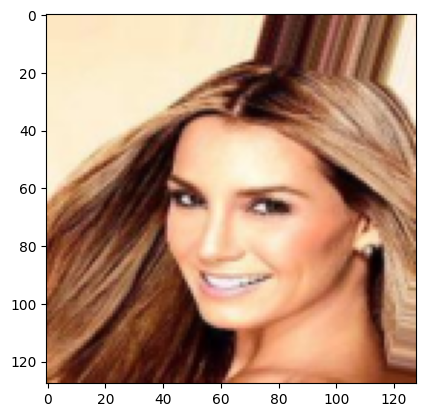

In [13]:
image = to_pil_image(training_data[0][0])
plt.imshow(image)

torch.Size([3, 128, 128])


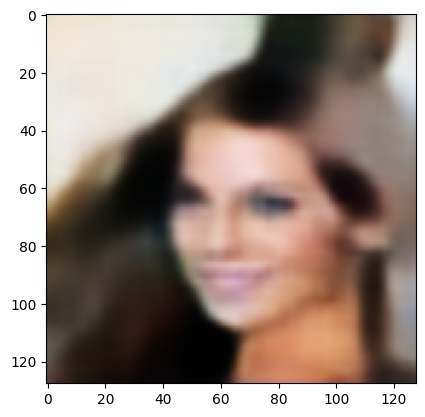

In [43]:
X = training_data[0][0].unsqueeze(0).to(device)
X_re, _, _ = vae(X)
X_re = X_re.squeeze(0)
print(X_re.shape)
to_pil_image(X_re).save("../data/image0.jpg")
plt.imshow(to_pil_image(X_re))

In [ ]:
vae.

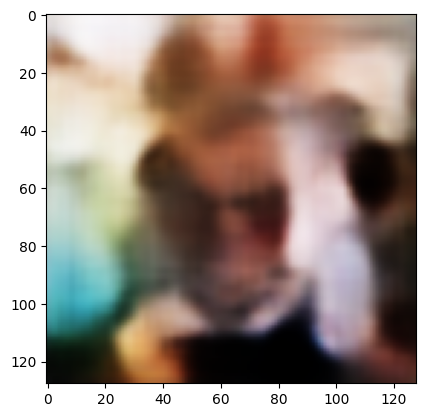

In [42]:
X = (torch.randn(512)).unsqueeze(0).to(device)
X_re = vae.decoder(X).squeeze(0)
plt.imshow(to_pil_image(X_re))

In [332]:
with open('../models/vae_promising.pkl', 'wb') as f:
  pkl.dump(vae, f)

## Analysis of our latent space

Now that we have trained an apparently satisfying VAE, we would like to check if our latent representations are well balanced in the latent space, ie test if the embeddings of the images are distributed among a multivariate standard normal distribution.

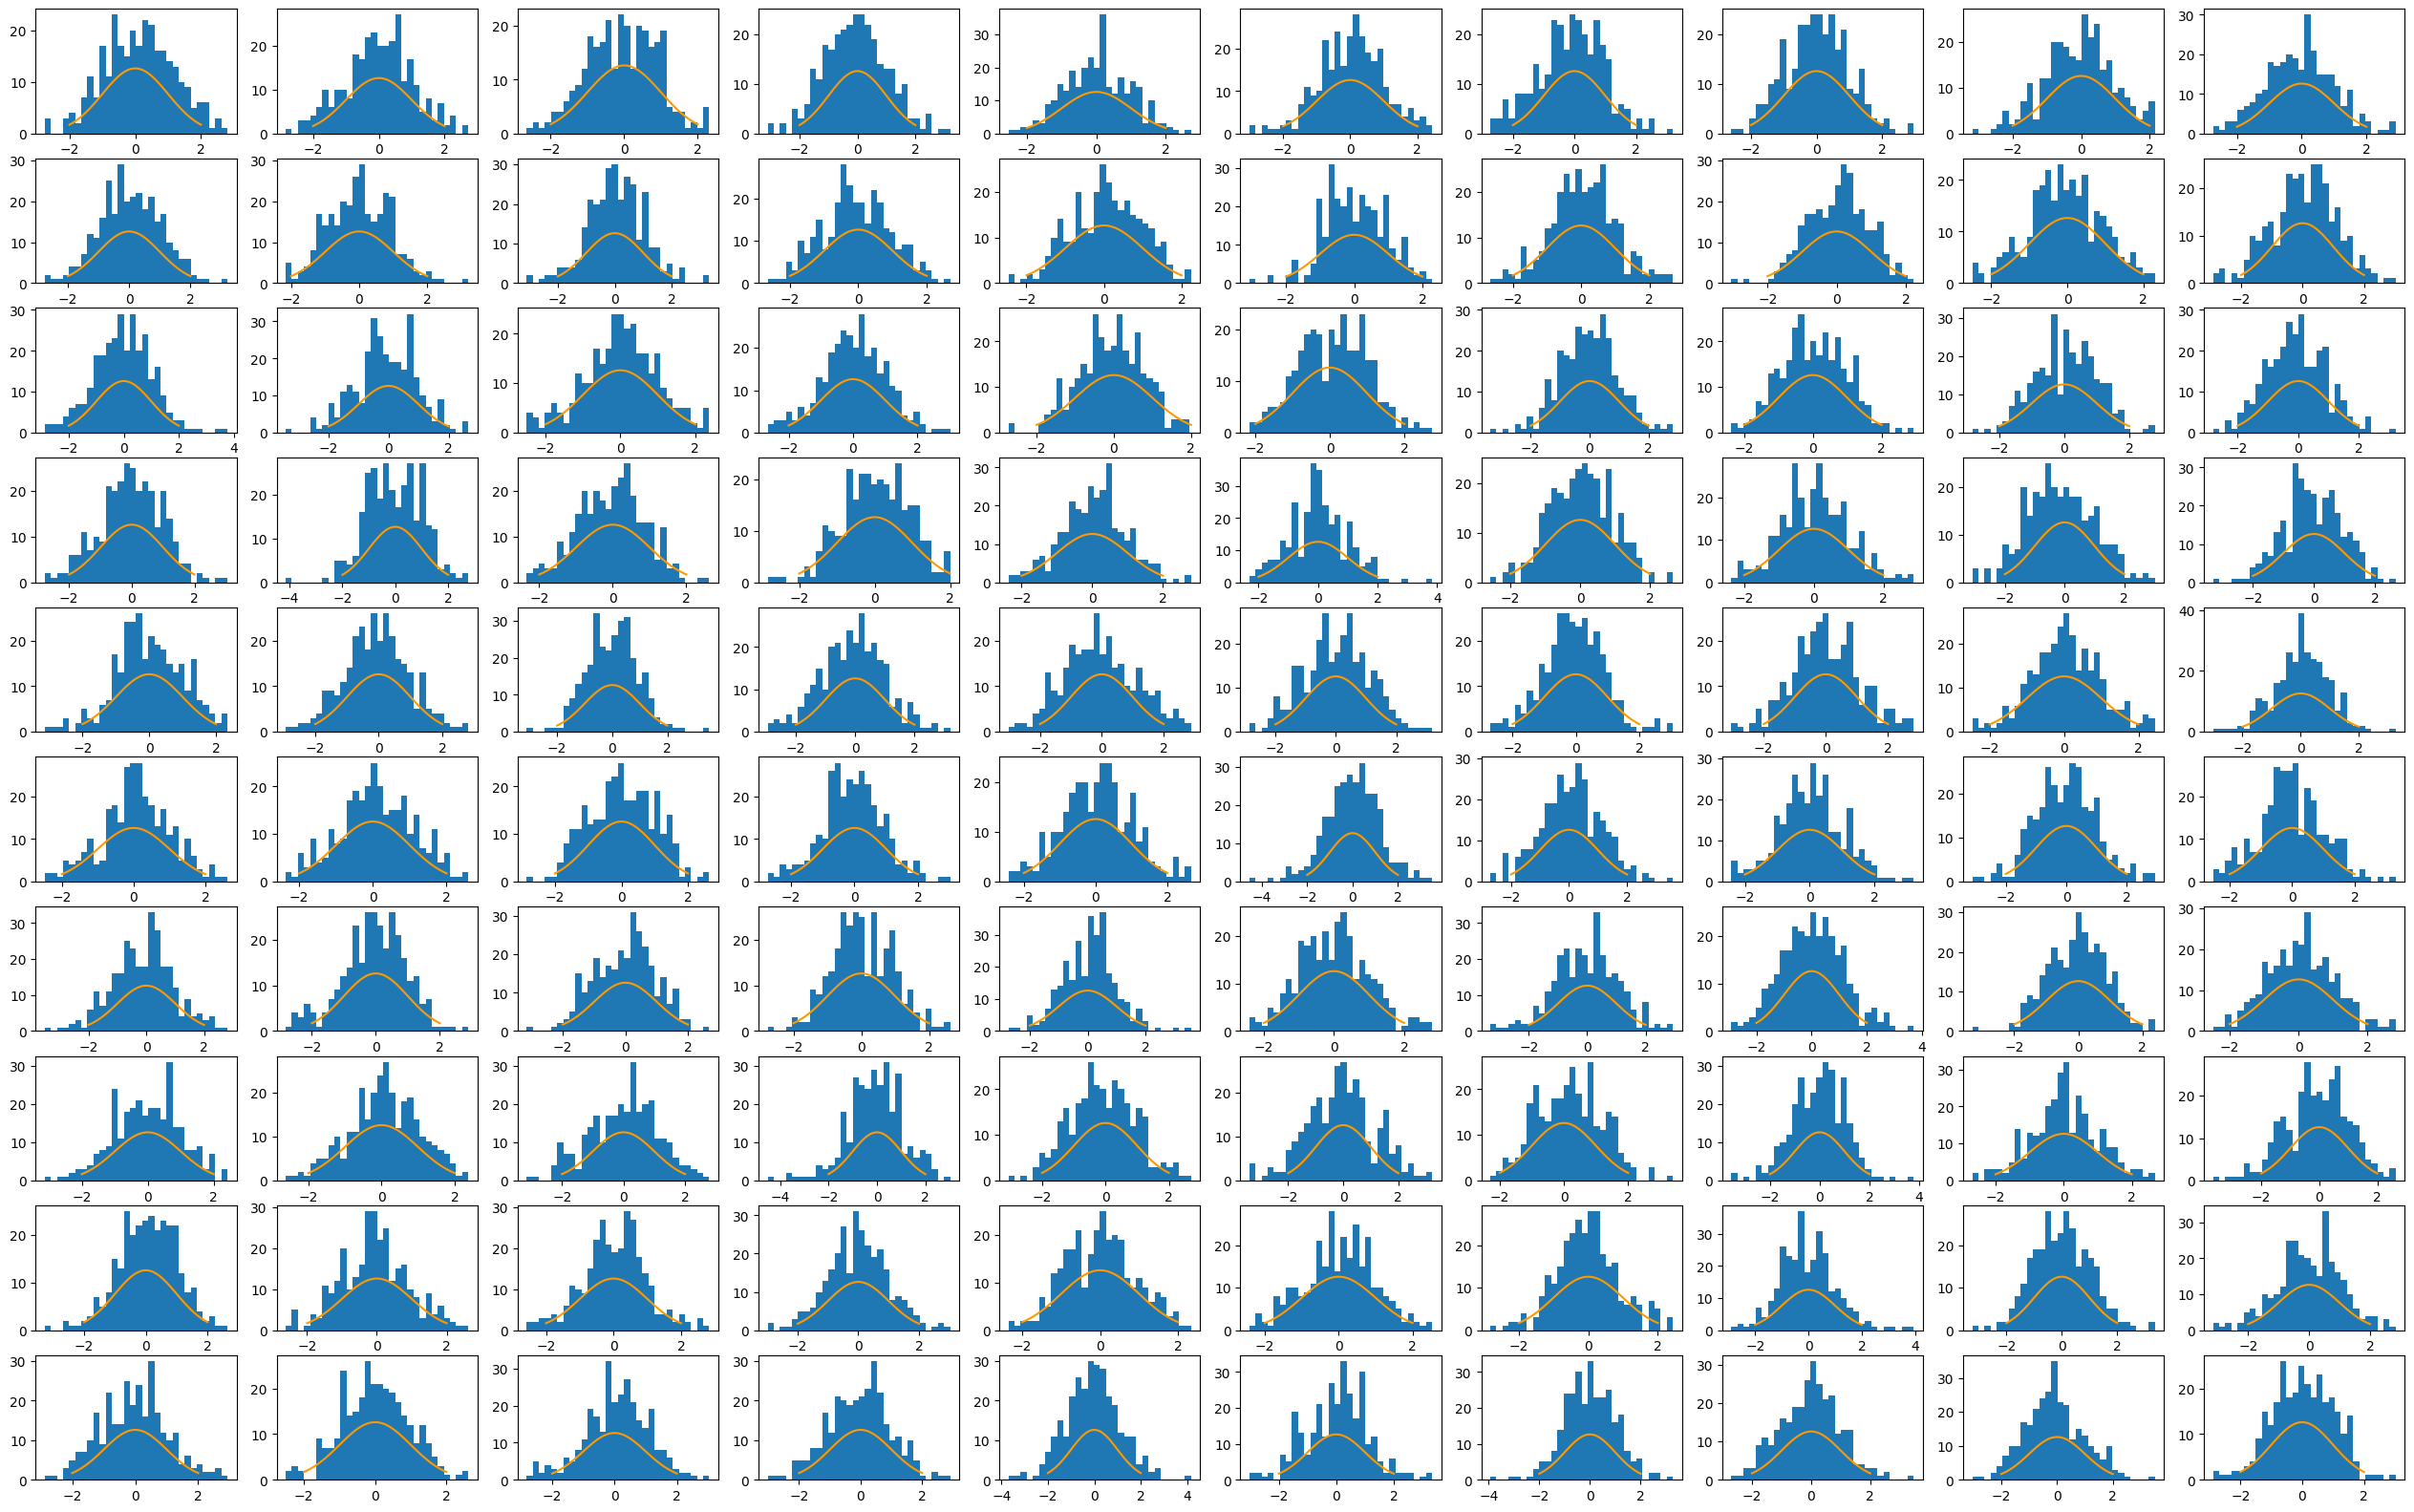

In [286]:
# Conducting our study on a batch of 1000 elements
X_batch = []
for i in range(1000):
    X_batch.append(training_data[i][0].unsqueeze(0))
X_batch = torch.concatenate(X_batch).to(device) # (1000, 3, 128, 128)

# Getting the latent representations
X_enc, _, _ = vae.encoder(X_batch) # (1000, 2000)

# We only plot for the first 100 dimensions
feature = 0
n_rows = 10
n_cols = 10
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(32, 20))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i, j].hist(X_enc[:][i*10+j].detach().cpu().numpy(), bins = 30)
        # Plotting the standard normal for reference
        X = np.linspace(-2, 2, 100)
        y = np.sqrt(1000/(2*np.pi)) * np.exp(-X**2/2)
        ax[i, j].plot(X, y, c='#FF9900')


There is apparently no dimension that looks particularly un-Gaussian. Now let's play with that creation.

## Image Generation

We have now confirmation that we can simply sample a random vector in the latent space according to a standard normal distribution, and pass it through the decoder to generate new faces.

In [1]:
X = torch.randn(300).unsqueeze(0).to(device)
print(X.shape)
X_re = vae.decoder(X).clamp(0,1).squeeze(0)
print(X_re.shape)
plt.imshow(to_pil_image(X_re))

NameError: name 'torch' is not defined

In [56]:
to_pil_image(X_re).save("../data/meme.jpg")

## Playing with attributes

It is now (finally !) time to play with the attributes of the dataset, which have until now been completely ignored.

In [24]:
import pandas as pd

In [25]:
attributes = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young".split(' ')

In [26]:
dict_attributes= {k:i for i, k in enumerate(attributes)}

In [27]:
print(dict_attributes)

{'5_o_Clock_Shadow': 0, 'Arched_Eyebrows': 1, 'Attractive': 2, 'Bags_Under_Eyes': 3, 'Bald': 4, 'Bangs': 5, 'Big_Lips': 6, 'Big_Nose': 7, 'Black_Hair': 8, 'Blond_Hair': 9, 'Blurry': 10, 'Brown_Hair': 11, 'Bushy_Eyebrows': 12, 'Chubby': 13, 'Double_Chin': 14, 'Eyeglasses': 15, 'Goatee': 16, 'Gray_Hair': 17, 'Heavy_Makeup': 18, 'High_Cheekbones': 19, 'Male': 20, 'Mouth_Slightly_Open': 21, 'Mustache': 22, 'Narrow_Eyes': 23, 'No_Beard': 24, 'Oval_Face': 25, 'Pale_Skin': 26, 'Pointy_Nose': 27, 'Receding_Hairline': 28, 'Rosy_Cheeks': 29, 'Sideburns': 30, 'Smiling': 31, 'Straight_Hair': 32, 'Wavy_Hair': 33, 'Wearing_Earrings': 34, 'Wearing_Hat': 35, 'Wearing_Lipstick': 36, 'Wearing_Necklace': 37, 'Wearing_Necktie': 38, 'Young': 39}


Let's start with computing the old-young vector.

In [ ]:
X_male = []
X_female = []
idx=0
vae.eval()
while len(X_male)<5000 and len(X_female)<5000:
    face = training_data[idx]
    if face[1][dict_attributes["Male"]].item()==1:
        X_male.append(face[0].unsqueeze(0))
    else:
        X_female.append(face[0].unsqueeze(0))
    idx+=1

X_male = torch.concatenate(X_male, axis=0).to(device)
X_female = torch.concatenate(X_female, axis=0).to(device)

male_enc, _, _ = vae.encoder(X_male)
female_enc, _, _ = vae.encoder(X_female)

female_male_vector = torch.mean(male_enc, axis=0) - torch.mean(female_enc, axis=0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 684.00 MiB. GPU 0 has a total capacity of 23.53 GiB of which 141.75 MiB is free. Including non-PyTorch memory, this process has 23.24 GiB memory in use. Of the allocated memory 22.49 GiB is allocated by PyTorch, and 510.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [80]:
X_fat = []
X_slim = []
idx=0
vae.eval()
while len(X_fat)<1000 and len(X_slim)<1000:
    face = training_data[idx]
    if face[1][dict_attributes["Mustache"]].item()==1:
        X_fat.append(face[0].unsqueeze(0))
    else:
        X_slim.append(face[0].unsqueeze(0))
    idx+=1
print(len(X_fat))

X_fat = torch.concatenate(X_fat, axis=0).to(device)
X_slim = torch.concatenate(X_slim, axis=0).to(device)

fat_enc, _, _ = vae.encoder(X_fat)
slim_enc, _, _ = vae.encoder(X_slim)

nose_vector = torch.mean(fat_enc, axis=0) - torch.mean(slim_enc, axis=0)

35


In [295]:
female_male_vector.shape

torch.Size([300])

In [51]:
test = training_data[5][0].unsqueeze(0).to(device)
emb, _, _ = vae.encoder(test)
emb += nose_vector

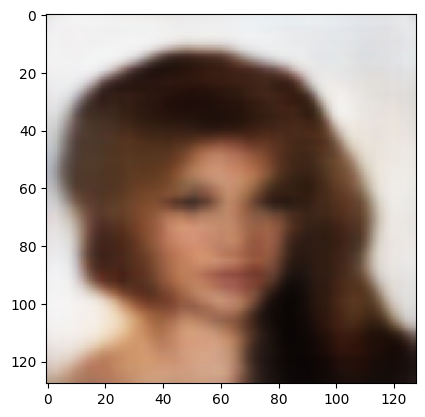

In [52]:
rec, _, _ = vae(test)
plt.imshow(to_pil_image(rec.clamp(0,1).squeeze(0)))

torch.Size([3, 128, 128])


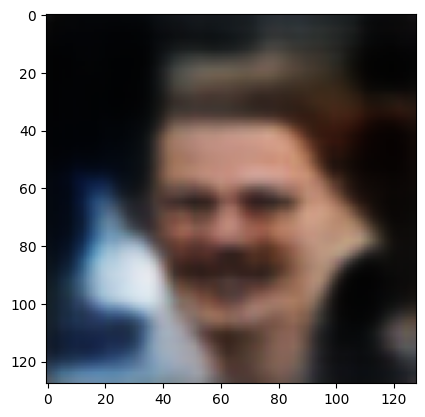

In [43]:
emb += 2*nose_vector
male_test = vae.decoder(emb).clamp(0,1).squeeze(0)
print(male_test.shape)
plt.imshow(to_pil_image(male_test))

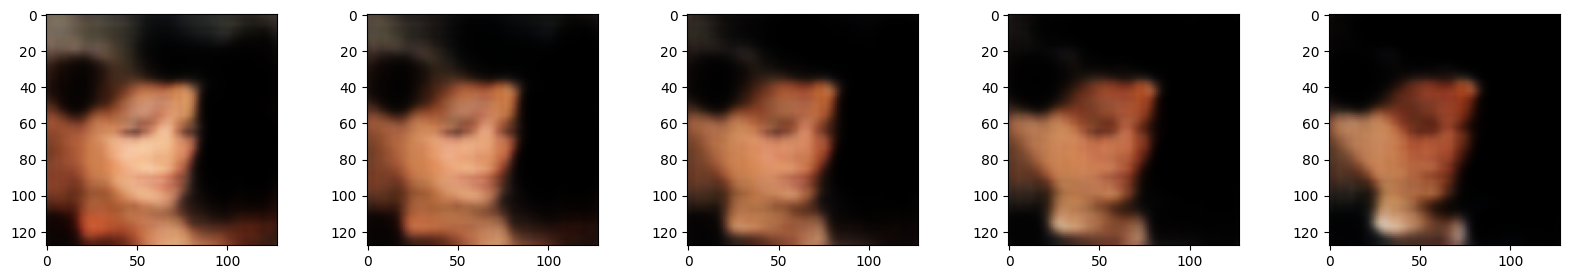

In [83]:
fig, ax = plt.subplots(nrows = 1, ncols=5, figsize=(20,3))

test = training_data[3][0].unsqueeze(0).to(device)
emb, _, _ = vae.encoder(test)
emb -= 3*nose_vector
for i in range(5):
    emb += nose_vector
    reconst = vae.decoder(emb).clamp(0,1).squeeze(0)
    ax[i].imshow(to_pil_image(reconst))

# GAN

In [8]:
batch_size = 64

training_data = CelebA(
    root="data",
    split='train',
    download=True,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()])
) # [Tensor(3, 128, 128), int]
test_data = CelebA(
    root="data",
    split='test',
    download=True,
    transform={
        transforms.Resize((128, 128)),
        transforms.ToTensor()}
) # [Tensor(3, 128, 128), int]

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True) # Tensor(64, 1, 28, 28), Tensor(64)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, channels, kernels, strides=None):
        super().__init__()
        self.n_layers = len(channels)
        if strides is None:
            strides = [1]*self.n_layers

        layers = []
        self.input_shape = input_shape # (C, W, H)
        in_chan = input_shape[0]
        for out_chan, k, s in zip(channels, kernels, strides):
            layers.append(nn.Conv2d(in_chan, out_chan, kernel_size=k, stride=s))
            layers.append(nn.BatchNorm2d(num_features=out_chan))
            layers.append(nn.ReLU())
            in_chan = out_chan
        self.conv_layers = nn.Sequential(*layers)

        with torch.no_grad():
            dummy = torch.zeros(1, *self.input_shape)
            dummy_output = self.conv_layers(dummy)
            self.output_shape = dummy_output.shape[1:]
            final_dim = dummy_output.flatten(1).shape[1]

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(final_dim, 1)
        self.act = nn.Sigmoid()
        return None

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.act(x)
        return x

In [25]:
class PatchArtefactGenerator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,8,3),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8,32,3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            out = self.conv1(dummy)
            out = self.conv2(out)
            out = self.conv3(out)
            self.inner_shape = out.shape[1:]
            flat_size = out.flatten(1).shape[1]

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(32,8,3,1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU()
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(8,3,3,1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU()
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.flatten(x)
        #x = self.fc(x)
        #x = x.reshape((x.size(0),*self.inner_shape))
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x

In [34]:
dis = Discriminator(input_shape=(3,128,128),
                    channels=[8, 32, 64],
                    kernels = [3,3,3],)

In [35]:
gen = PatchArtefactGenerator((3,128,128))

In [19]:
def train_discriminator(discriminator, generator, vae, training_data, batch_size, criterion, optimizer, device):
    discriminator.train()
    # Train on real data
    optimizer.zero_grad()
    idx = np.random.randint(0, len(training_data), batch_size)
    real_data = torch.concatenate([training_data[i][0].unsqueeze(0) for i in idx]).to(device)
    labels_re = torch.ones(batch_size,1).to(device)
    predicted_re = discriminator(real_data)
    re_loss = criterion(predicted_re, labels_re)
    re_loss.backward()
    optimizer.step()

    # Train on generated data
    optimizer.zero_grad()
    idx = np.random.randint(0, len(training_data), batch_size)
    real_data = torch.concatenate([training_data[i][0].unsqueeze(0) for i in idx]).to(device)
    generated_images = generator(vae(real_data)[0])
    labels_gen = torch.zeros(batch_size,1).to(device)
    predicted_gen = discriminator(generated_images)
    gen_loss = criterion(predicted_gen, labels_gen)
    gen_loss.backward()
    optimizer.step()

    return re_loss, gen_loss


In [30]:
def train_generator(generator, discriminator, vae, batch_size, criterion, optimizer, device):
    generator.train()
    optimizer.zero_grad()
    idx = np.random.randint(0, len(training_data), batch_size)
    real_data = torch.concatenate([training_data[i][0].unsqueeze(0) for i in idx]).to(device)
    generated = generator(vae(real_data)[0])
    labels = torch.ones(batch_size,1).to(device)
    predicted = discriminator(generated)
    loss = criterion(predicted, labels)
    loss.backward()
    optimizer.step()
    return loss

In [36]:
criterion = nn.BCELoss()
dis_optimizer = Adam(dis.parameters(), lr=1e-4)
gen_optimizer = Adam(gen.parameters(), lr=1e-4)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
gen = gen.to(device)
dis = dis.to(device)
vae = vae.to(device)
for epoch in range(5000):
    re_loss, gen_loss = train_discriminator(dis, gen, vae, training_data=training_data, batch_size=4, criterion=criterion, optimizer=dis_optimizer, device='cuda')
    loss = train_generator(gen, dis, vae, batch_size=2, criterion=criterion, optimizer=gen_optimizer, device=device)
    if epoch % 20 == 0:
        print(f"Epoch {epoch} :")
        print("Discriminator :")
        print(f"Real : {re_loss}")
        print(f"Generated : {gen_loss}\n")
        print(f"Generator : {loss}\n")

Epoch 0 :
Discriminator :
Real : 0.0
Generated : 3.2128357887268066

Generator : 100.0

Epoch 20 :
Discriminator :
Real : 1.3674556016921997
Generated : 1.1975792801877105e-08

Generator : 81.32598114013672

Epoch 40 :
Discriminator :
Real : 0.0
Generated : 0.0

Generator : 50.0

Epoch 60 :
Discriminator :
Real : 1.6938551664352417
Generated : 25.0

Generator : 78.46016693115234

Epoch 80 :
Discriminator :
Real : 0.0
Generated : 1.0054570023787512e-12

Generator : 100.0

Epoch 100 :
Discriminator :
Real : 0.0
Generated : 0.0021831297781318426

Generator : 100.0

Epoch 120 :
Discriminator :
Real : 0.0
Generated : 0.0

Generator : 100.0

Epoch 140 :
Discriminator :
Real : 0.0
Generated : 0.0

Generator : 100.0

Epoch 160 :
Discriminator :
Real : 3.5866894721984863
Generated : 0.0

Generator : 100.0

Epoch 180 :
Discriminator :
Real : 4.718630790710449
Generated : 25.00056266784668

Generator : 100.0

Epoch 200 :
Discriminator :
Real : 0.0
Generated : 3.133994682197705e-22

Generator : 10

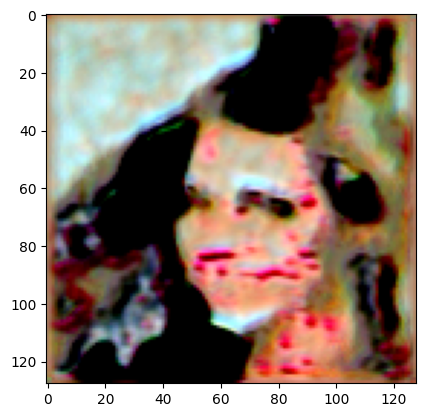

In [69]:
X_re, _, _ = vae(training_data[0][0].unsqueeze(0).to(device))
X_re = X_re.clamp(0,1)
image = gen(X_re).squeeze(0).clamp(0,1)
plt.imshow(to_pil_image(image))

In [14]:
import matplotlib.pyplot as plt
import numpy as numpy
import torch
from torchvision.datasets import CelebA
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.optim import Adam
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import pickle as pkl
from torchvision.transforms.functional import to_pil_image


class Encoder(nn.Module):
  def __init__(self, input_shape, latent_dim, channels, kernels, stride=(2,2)):
    """
    input_shape : (Channels, Height, Width)
    kernel_size : (height, width)
    N convolutional layers -> channels_in, channels_out, kernel_size, stride for each
    Flatten
    2 Linear layers -> mu, logvar
    One Lambda layer
    """
    super().__init__()

    self.n_layers = len(channels)

    strides = [stride]*self.n_layers

    layers = []
    in_chan = input_shape[0]

    for out_chan, k, s in zip(channels, kernels, strides):
      layers.append(nn.Conv2d(in_chan, out_chan, k, s, padding=1))
      layers.append(nn.BatchNorm2d(out_chan))
      layers.append(nn.LeakyReLU(0.2))
      in_chan = out_chan

    self.layers = nn.Sequential(*layers)
    self.flatten = nn.Flatten()

    with torch.no_grad():
      dummy = torch.zeros(1, *input_shape)
      dummy_output = self.layers(dummy)
      self.inner_shape = dummy_output.shape[1:]
      self.flat_size = dummy_output.flatten(1).shape[1]

    self.mu = nn.Linear(self.flat_size, latent_dim)
    self.logvar = nn.Linear(self.flat_size, latent_dim)

  def forward(self, x):
    x = self.layers(x)
    x = self.flatten(x)
    mu, logvar = self.mu(x), self.logvar(x)
    output = mu + torch.exp(0.5*logvar)*torch.randn_like(logvar)
    return output, mu, logvar


class Decoder(nn.Module):
  def __init__(self, inner_shape, flat_size, latent_dim, channels, kernels, scale_factor=2, target_shape=None):
    """
    Initialize a decoder for a VAE model
    Parameters :
      - inner_shape (tuple) : shape of the inner layer of the decoder
      - flat_size (int) : size of the flattened layer
      - latent_dim (int) : dimension of the latent space
      - channels (list) : list of the number of channels for each layer
      - kernels (list) : list of the kernel size for each layer
      - scale_factor (int) : scale factor for the upsampling
      - target_shape (tuple) : shape of the target image
    """
    super().__init__()

    self.n_layers = len(channels)
    self.inner_shape = inner_shape
    self.target_shape = target_shape

    scale_factors = [scale_factor]*self.n_layers

    layers = []
    in_chan = inner_shape[0]
    for i, (out_chan, k) in enumerate(zip(channels, kernels)):
      if i>0:
        layers.append(nn.Upsample(scale_factor=2, mode='nearest'))

      layers.append(nn.Conv2d(in_chan, out_chan, kernel_size=k, stride=1, padding=1))

      if i < len(channels)-1:
        layers.append(nn.BatchNorm2d(out_chan))
        layers.append(nn.LeakyReLU(0.2))

      in_chan = out_chan
    
    self.fc = nn.Linear(latent_dim, flat_size)#, bias=False)
    self.conv = nn.Sequential(*layers)
    self.final_act = nn.Sigmoid()


  def forward(self, x):
    x = self.fc(x)
    x = x.reshape((x.size(0),)+self.inner_shape)
    x = self.conv(x)
    x = self.final_act(x)
    if self.target_shape is not None:
      x = nn.functional.interpolate(x, size=self.target_shape, mode='bilinear', align_corners=False)
    return x
  

class VAE(nn.Module):
  def __init__(self, input_shape, channels_enc, channels_dec, kernel_enc, kernel_dec, stride_enc=(2,2), scale_factor=2, latent_dim = 200, target_shape=(128,128)):
    """
    Initialize an instance of variational auto-encoder.
    Parameters :
      - input_shape : shape of the image (channel, height, width)
      - channels encoder : number of channels between each layer of the encoder
      - channels decoder : same for the decoder
      - kernel_enc : array containing in order the kernel size of each convolutional layer of the encoder
      - kernel_dec : array containing in order the kernel size of each convolutional layer of the decoder
      - stride_enc : array containing in order the stride of each convolutional layer of the encoder
      - stride_dec : array containing in order the stride of each convolutional layer of the decoder
      - latent_dim : dimension of the latent space to which we project
    """
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(input_shape=input_shape, latent_dim=latent_dim, channels=channels_enc, kernels=kernel_enc, stride=stride_enc)
    self.decoder = Decoder(inner_shape=self.encoder.inner_shape, flat_size=self.encoder.flat_size, latent_dim=latent_dim, channels=channels_dec, kernels=kernel_dec, scale_factor=scale_factor, target_shape=target_shape)

  def forward(self, x):
    x, mu, logvar = self.encoder(x)
    x = self.decoder(x)
    return x, mu, logvar

In [17]:
def load_CelebA(split='train', root="data"):
    """
    Load the CelebA dataset.
    Parameters :
        - split : 'train' or 'test'
        - root (str) : path to the dataset if already downloaded, else the path to the dataset will be created
    Returns :
        - data (torch.utils.data.Dataset) : CelebA dataset 
    """
    if split != 'train' and split != 'test':
        raise ValueError("split must be either train or test !")
    data = CelebA(
        root=root,
        split=split,
        download=True,
        transform=Compose([
            Resize((128, 128)),
            ToTensor()])
    ) 
    return data

dataset = load_CelebA(split='train', root="../data")

In [60]:
def plot_reconstruction(idx, dataset, vae, device, seed=42):
    """
    Plot the image dataset[idx] and the reconstruction of the image by the VAE
    """
    vae = vae.to(device)
    vae.eval()
    face = dataset[idx]
    X_true = face[0].unsqueeze(0).to(device)
    X_reconst, _, _ = vae(X_true)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(X_true.squeeze(0).permute((1,2,0)))
    axs[0].set_title('Original')
    axs[1].imshow(X_reconst.squeeze(0).detach().permute((1,2,0)))
    axs[1].set_title('Reconstruction')
    plt.show()

In [28]:
vae = torch.load("../models/modular_vae.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
vae_model = VAE(input_shape=(3,128, 128), channels_enc=[16, 32, 64], channels_dec=[32, 16, 3], kernel_enc=[3, 3, 3], kernel_dec=[3, 3, 3], stride_enc=(2, 2), scale_factor=2, latent_dim=200)
vae_model.load_state_dict(vae)

<All keys matched successfully>

In [39]:
vae_model

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mu): Linear(in_features=16384, out_features=200, bias=True)
    (logvar): Linear(in_features=16384, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=200, out_features=16384, bias=True)
    (conv): Sequential(
      (0): Conv2d(

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

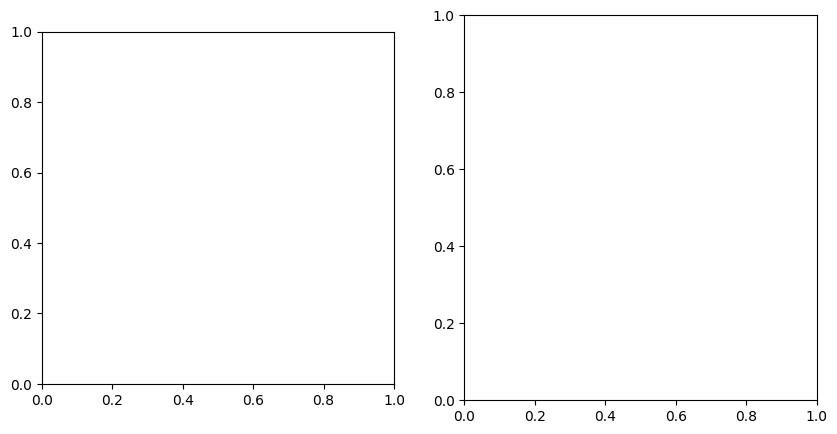

In [61]:
plot_reconstruction(0, dataset, vae_model, device)